# Intro: Bayesian Optimization using Hyperopt
This notebook covers the basics of Bayesian Model-Based Optimization using Hyperopt at a high level.

At a general level, there are four main parts to an optimization problem:

  1.   Objective function: what are we trying to minimize?
  2.   Domain Space: the values of the parameters over which to minimize the objective
  3.   Hyperparameter Optimization Function: constructs the surrogate function and chooses next values to evaluate. 
  4.   Trials: score, parameter pairs recorded each time the objective function is evaluated


Evaluating the objective function most obviously is the most "expensive" component of optimization both in terms of time and computing resources. In order to counter this, we can limit calls by choosing the next values to try in the objective function based on the past results. This is where Bayesian optimization shines compared to grid search or random search; we are able to utilize the past results to try more promising values for future iterations. 

Essentially, after each evaluation of the objective function, we can update the probability model and incorporate the new results. Sequential Model-Based Optimization methods are a formalization of Bayesian optimization that updates the probability model sequentially (i.e. every evaluation of the objective function with a set of values updates the model with the goal being that eventually the model will converge and represent the true objective function. 

Additionally, instead of a brute force like method of trying every parameter and evaluating every instance, we can use a criteria called Expected Improvement to preliminarily determine which values for the hyperparameters might yield the greatest expected improvement in the surrogate function rather than spending the time and computational resources to evaluate the objective function itself. 

# Sequential Model Based Optimization using the Tree Parzen Estimator

A few SMBO methods are the following:
  1.   Gaussian Processes
  2.   Tree-structured Parzen Estimator
  3.   Random Forest Regression

# Hyperopt

Hyperopt is a Python library for Bayesian optimization that implements SMBO using the Tree-structured Parzen Estimator. There are other libraries available that implement a Gaussian Process or Random Forest Regression for the surrogate function or probability model. 






In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Objective Function

For the objective function, I will use a simple polynomial function aimed at finding the minimum values (global minimum range as well as well one local minimum). 

It is important to ensure that the objective function returns a single real-value number to minimize. For example, if we use a metric like accuracy, then we would have to return the *negative* of accuracy to enable our model to find a better accuracy. 

In [4]:
def objective(x):
    """Objective function to minimize"""
    
    # Create the polynomial object
    f = np.poly1d([1, -2, -28, 28, 12, -26, 100])

    # Return the value of the polynomial
    return f(x) * 0.05

Minimum of -219.8012 occurs at 4.8779


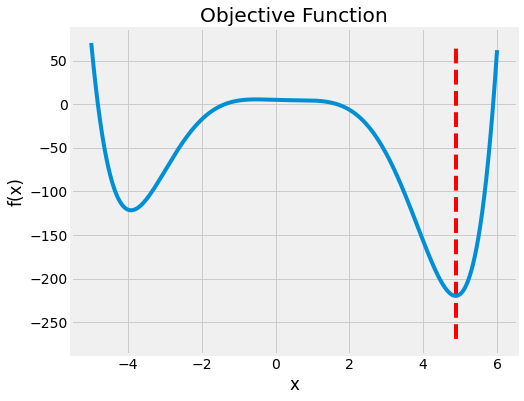

In [5]:
# Space over which to evluate the function is -5 to 6
x = np.linspace(-5, 6, 10000)
y = objective(x)

miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function'); plt.xlabel('x'); plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '--', colors = 'r')
plt.plot(x, y);

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

# Domain

The domain is the values of x over which we evaluate the function. We can use a uniform distribution over the space that our function is defined. 

In [6]:
from hyperopt import hp

# Create the domain space
space = hp.uniform('x', -5, 6)

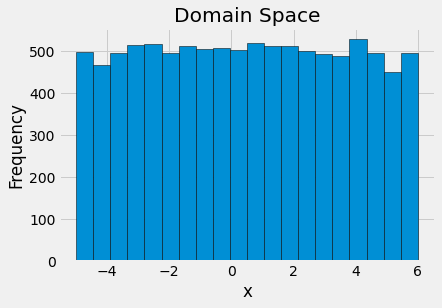

In [7]:
from hyperopt.pyll.stochastic import sample

samples = []

# Sample 10000 values from the range
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 20, edgecolor = 'black'); 
plt.xlabel('x'); plt.ylabel('Frequency'); plt.title('Domain Space');

# Hyperparameter Optimization Algorithm
There are two choices for the hyperparameter optimization algorithm in Hyperopt:

  1.   Tree Parzen Estimator
  2.   Random

In [8]:
from hyperopt import rand, tpe

# Create the algorithms
tpe_alg = tpe.suggest
rand_alg = rand.suggest

# History Using Trials

Storing the history can be achieved relatively simply by making a Trials object that is passed into the function call

In [9]:
from hyperopt import Trials

# Create two trials objects
tpe_trials = Trials()
rand_trials = Trials()


## Run the Optimization
Now, we can run a specified number of minimization runs with both the random algorithm and the Tree Parzen Estimator Algorithm.

The *fmin* function takes in the four parts discussed above -- objective, space, algorithm type, trials, max_evals and rstate

In [11]:
from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=objective, space=space, algo=tpe_alg, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

print(tpe_best)

# Run 2000 evals with the random algorithm
rand_best = fmin(fn=objective, space=space, algo=rand_alg, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.RandomState(50))



100%|██████████| 2000/2000 [00:15<00:00, 128.99it/s, best loss: -219.80118811219114]
{'x': 4.878481851906148}
100%|██████████| 2000/2000 [00:04<00:00, 481.30it/s, best loss: -219.80116907646868]


In [12]:
# Print out information about losses
print('Minimum loss attained with TPE:    {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss attained with random: {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x):            {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))



Minimum loss attained with TPE:    -219.8012
Minimum loss attained with random: -219.8012
Actual minimum of f(x):            -219.8012

Number of trials needed to attain minimum with TPE:    655
Number of trials needed to attain minimum with random: 235

Best value of x from TPE:    4.8785
Best value of x from random: 4.8776
Actual best value of x:      4.8779


# Results
Both models returned values considerably close to the optimal value. To get more detailed information, we can look further into the trials objects.


In [13]:
tpe_results = pd.DataFrame({'loss': [x['loss'] for x in tpe_trials.results], 'iteration': tpe_trials.idxs_vals[0]['x'],
                            'x': tpe_trials.idxs_vals[1]['x']})
                            
tpe_results.head()

,loss,iteration,x
0,36.210073,0,5.957885
1,-202.384052,1,4.470885
2,-75.519449,2,3.218963
3,5.543552,3,-0.515859
4,35.078011,4,-4.916832


In [14]:
tpe_results['rolling_average_x'] = tpe_results['x'].rolling(50).mean().fillna(method = 'bfill')
tpe_results['rolling_average_loss'] = tpe_results['loss'].rolling(50).mean().fillna(method = 'bfill')
tpe_results.head()

,loss,iteration,x,rolling_average_x,rolling_average_loss
0,36.210073,0,5.957885,2.105103,-74.393795
1,-202.384052,1,4.470885,2.105103,-74.393795
2,-75.519449,2,3.218963,2.105103,-74.393795
3,5.543552,3,-0.515859,2.105103,-74.393795
4,35.078011,4,-4.916832,2.105103,-74.393795


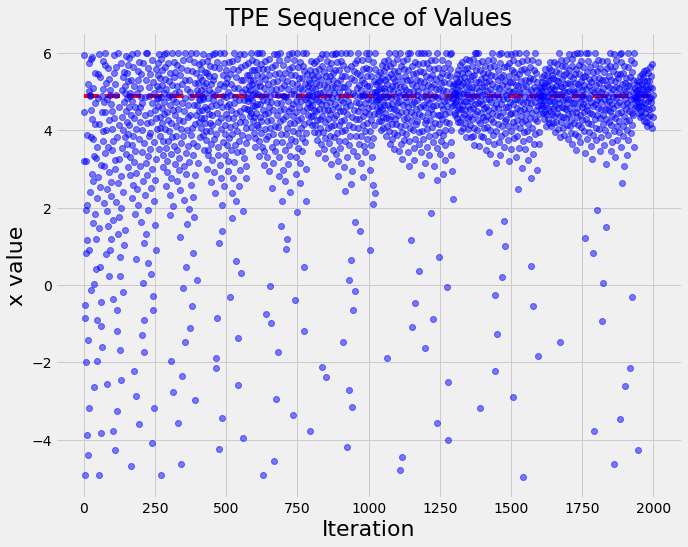

In [15]:
plt.figure(figsize = (10, 8))
plt.plot(tpe_results['iteration'], tpe_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('TPE Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

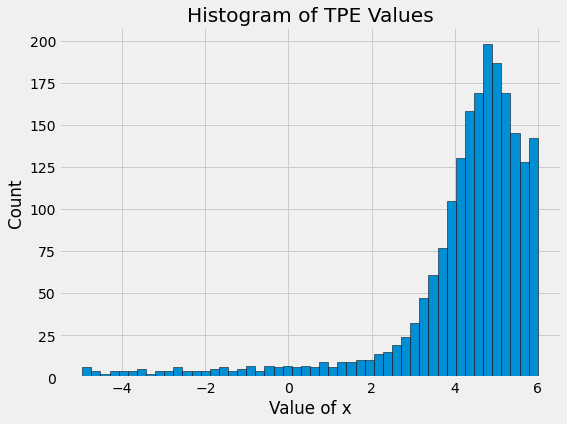

In [16]:
plt.figure(figsize = (8, 6))
plt.hist(tpe_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of TPE Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

Best Loss of -219.8012 occured at iteration 655


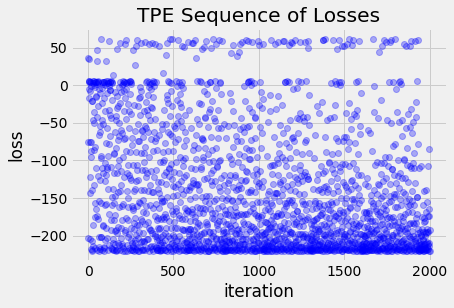

In [17]:
# Sort with best loss first
tpe_results = tpe_results.sort_values('loss', ascending = True).reset_index()
plt.plot(tpe_results['iteration'], tpe_results['loss'], 'bo', alpha = 0.3);
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('TPE Sequence of Losses')
print('Best Loss of {:.4f} occured at iteration {}'.format(tpe_results['loss'][0], tpe_results['iteration'][0]))

# Random Results
The random results can be compared and contrasted. 


In [19]:
rand_results = pd.DataFrame({'loss': [x['loss'] for x in rand_trials.results], 'iteration': rand_trials.idxs_vals[0]['x'],
                            'x': rand_trials.idxs_vals[1]['x']})
                            
rand_results.head()

,loss,iteration,x
0,36.210073,0,5.957885
1,-202.384052,1,4.470885
2,-75.519449,2,3.218963
3,5.543552,3,-0.515859
4,35.078011,4,-4.916832


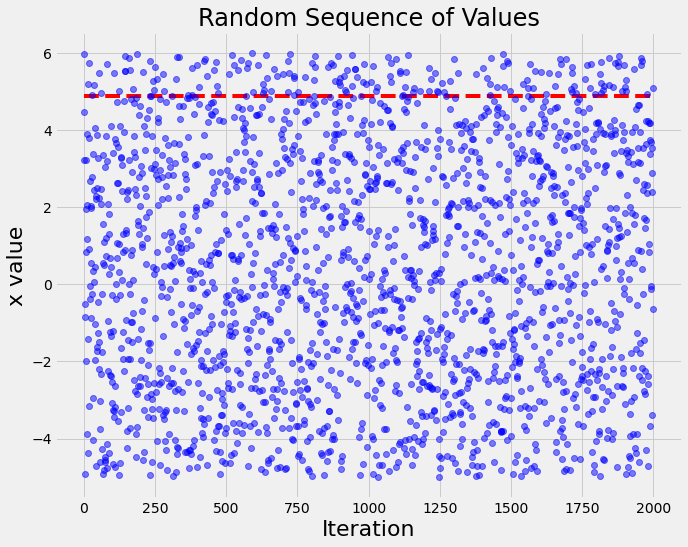

In [20]:
plt.figure(figsize = (10, 8))
plt.plot(rand_results['iteration'], rand_results['x'],  'bo', alpha = 0.5);
plt.xlabel('Iteration', size = 22); plt.ylabel('x value', size = 22); plt.title('Random Sequence of Values', size = 24);
plt.hlines(minx, 0, 2000, linestyles = '--', colors = 'r');

Best Loss of -219.8012 occured at iteration 235


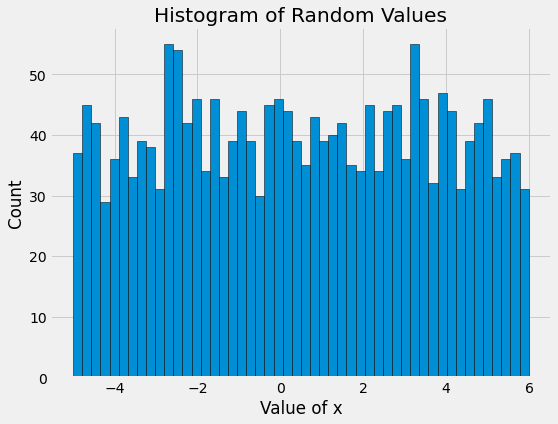

In [21]:
# Sort with best loss first
rand_results = rand_results.sort_values('loss', ascending = True).reset_index()
plt.figure(figsize = (8, 6))
plt.hist(rand_results['x'], bins = 50, edgecolor = 'k');
plt.title('Histogram of Random Values'); plt.xlabel('Value of x'); plt.ylabel('Count');

# Print information
print('Best Loss of {:.4f} occured at iteration {}'.format(rand_results['loss'][0], rand_results['iteration'][0]))